In [153]:
from gurobipy import *
import random as rd
import json
import pandas as pd

### Rapide visualisation des données

In [154]:
path = './data/medium.json'
f = open(path)
data = json.load(f)
data.keys()
f.close()

In [155]:
data['horizon'], data['qualifications']

(22, ['F', 'G', 'A', 'D', 'J', 'C', 'H', 'E', 'B', 'I'])

In [156]:
data['staff']

[{'name': 'Olivia', 'qualifications': ['A', 'B', 'C'], 'vacations': [1, 2]},
 {'name': 'Liam', 'qualifications': ['A', 'D', 'E'], 'vacations': [1, 2]},
 {'name': 'Emma', 'qualifications': ['B', 'H'], 'vacations': [8, 9]},
 {'name': 'Noah',
  'qualifications': ['G', 'D', 'J', 'C', 'H', 'I'],
  'vacations': []},
 {'name': 'Amelia',
  'qualifications': ['F', 'G', 'J', 'E'],
  'vacations': [16, 15]}]

In [157]:
data['jobs'][0]

{'name': 'Job1',
 'gain': 15,
 'due_date': 20,
 'daily_penalty': 3,
 'working_days_per_qualification': {'A': 4, 'B': 4}}

## Modèle et variables

In [158]:
# Instanciation du modèle
m = Model()

# Chargement des données
path = './data/small.json'
with open(path) as f:
    data = json.load(f)

# Constantes
S = data['staff']
J = data['jobs']
Q = data['qualifications']
H = data['horizon']

# Création de variables
X = m.addMVar(shape=(len(S), len(J), len(Q), H), vtype=GRB.BINARY)
Y = m.addMVar(shape=len(J), vtype=GRB.BINARY)
L = m.addMVar(shape=len(J), vtype=GRB.INTEGER)
E = m.addMVar(shape=len(J), vtype=GRB.INTEGER)

works_on_job = m.addMVar(shape=(len(S), len(J)), vtype=GRB.BINARY)
max_nb_of_jobs = m.addVar(vtype=GRB.INTEGER)

job_worked_on = m.addMVar(shape=(len(J), H), vtype=GRB.BINARY)
max_duration_of_jobs = m.addVar(vtype=GRB.INTEGER)

start_date_projects = m.addMVar(shape=len(J), vtype=GRB.INTEGER)

# maj du modèle
m.update()

## Définition des contraintes

In [159]:
# C1: Sur un jour donné, une personne est maximum sur une compétence d'un seul projet
for i in range(len(S)):
    for t in range(H):
        m.addConstr(X[i, :, :, t].sum() <= 1)

# C2: Les membres du personnel ne travaillent pas sur leurs jours de congés
for i in range(len(S)):
    person = S[i]
    for t in person['vacations']:
            m.addConstr(X[i, :, :, t - 1].sum() == 0)

# C3: Un membre du personnel ne peut pas travailler sur un projet si il n'a pas une des compétences requises
for i in range(len(S)):
    person = S[i]
    for j in range(len(J)):
        job = J[j]
        for k in range(len(Q)):
            qualification = Q[k]
            if (qualification not in person['qualifications']) or (qualification not in list(job['working_days_per_qualification'].keys())):
                m.addConstr(X[i, j, k, :].sum() == 0)


for j in range(len(J)):
    job = J[j]
    for k in range(len(Q)):
        qualification = Q[k]
        if qualification in list(job['working_days_per_qualification'].keys()):
            njk = job['working_days_per_qualification'][qualification]

            # C4: Si le projet est réalisé, alors le nombre de jours mobilisé sur chaque compétence
            # du projet est au moins égal au nombre de jours requis
            m.addConstr(Y[j] * njk <= X[:, j, k, :].sum())

            # C5: Le nombre de jours passé sur chaque compétence du projet est au maximum égal
            # au nombre de jours requis
            m.addConstr(X[:, j, k, :].sum() <= njk)


# Définition de works_on_job : Indique si la personne i travaille sur le projet j
for i in range(len(S)):
    for j in range(len(J)):
        res = X[i, j].sum()
        m.addConstr(res <= 10000 * works_on_job[i, j]) # res >= 1 => works_on_job[i, j] = 1
        m.addConstr(res - 1 >= - 10000 * (1 - works_on_job[i, j])) # works_on_job[i, j] = 1 => res >= 1


# Définition de job_worked_on : Indique si quelqu'un a travaillé sur le projet j le jour t
for j in range(len(J)):
    for t in range(H):
        res = X[:, j, :, t].sum()
        m.addConstr(res <= 10000 * job_worked_on[j, t]) # res >= 1 => job_worked_on[i, j] = 1
        m.addConstr(res - 1 >= - 10000 * (1 - job_worked_on[j, t])) # job_worked_on[i, j] = 1 => res >= 1


for j in range(len(J)):
    # start_date_projects > 0
    m.addConstr(start_date_projects[j] >= 1)
    # start_date_projects <= H
    m.addConstr(start_date_projects[j] <= H)
    # Ej > 0
    m.addConstr(E[j] >= 1)
    # Ej <= H
    m.addConstr(E[j] <= H)
    for t in range(H):
        # C6: Personne ne travaille sur un projet déjà fini
        m.addConstr(job_worked_on[j, t] * t <= E[j] - 1)
        # Définition de start_date_projects
        m.addConstr(start_date_projects[j] - 1 <= t * job_worked_on[j, t])

for j in range(len(J)):
    # C7: Le nombre de jours de retard est au moins égal à l'écart entre la due date et la date de rendu
    job = J[j]
    dj = job["due_date"]
    m.addConstr(E[j] - dj <= L[j])

    # Lj >= 0
    m.addConstr(L[j] >= 0)


# Définition de max_nb_of_jobs: Nombre de projets maximal parmi le staff
for i in range(len(S)):
    m.addConstr(works_on_job[i].sum() <= max_nb_of_jobs)

# Contrainte de définition de max_len_job: Durée du plus long projet
for j in range(len(J)):
    m.addConstr(max_duration_of_jobs >= E[j] - start_date_projects[j])


m.update()

## Définition des fonctions objectifs

### Fonction objectif 1 : Maximiser le bénéfice

In [160]:
def benefice(J, Y, L):
    res = 0
    for j in range(len(J)):
        job = J[j]
        gj = job["gain"]
        cj = job["daily_penalty"]
        res += (Y[j] * gj - L[j] * cj)
    return res

m.setObjectiveN(
    - benefice(J, Y, L),
    0,
    0
)

### Fonction objectif 2 : Minimiser le nombre de projets sur lesquels un quelconque collaborateur est affecté

In [161]:
m.setObjectiveN(
    max_nb_of_jobs,
    1,
    0
)

### Fonction objectif 3 : Executer le projet le plus long en un minimum de jours

In [162]:
m.setObjectiveN(
    max_duration_of_jobs,
    2,
    0
)

## Résolution du problème

In [163]:
# # Paramétrage (mode mute)
# m.params.outputflag = 0
# Résolution du PL
m.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 230 rows, 287 columns and 1828 nonzeros
Model fingerprint: 0x47dc7765
Variable types: 0 continuous, 287 integer (270 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 3 objectives (1 combined) ...
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (weighted) ...
---------------------------------------------------------------------------

Optimize a model with 230 rows, 287 columns and 1828 nonzeros
Model fingerprint: 0x6c0e098b
Varia

In [164]:
nSolutions  = m.SolCount
nObjectives = m.NumObj
print('Problem has', nObjectives, 'objectives')
print('Gurobi found', nSolutions, 'solutions')

solutions = []
df = pd.DataFrame()
for s in range(nSolutions):
    m.params.SolutionNumber = s
    print(f"Solution {s}: ", end='')

    values = []
    for o in range(nObjectives):
        m.params.ObjNumber = o
        print(' ', m.ObjNVal, end='')
        values.append([m.ObjNVal])

    print('')
    print('------------------------------')
    print('Job done: Y = {}'.format(Y.Xn))
    print('Delay penalty: L = {}'.format(L.Xn))
    print('Finish date: E = {}'.format(E.Xn))
    print('Participates: works_on_job = {}'.format(works_on_job.Xn))
    solutions.append({
        "X": X.Xn,
        "Y": Y.Xn,
        "E": E.Xn,
        "L": L.Xn,
        "works_on_job": works_on_job.Xn
    })
    print('')
    df = pd.concat([
        df, pd.DataFrame(values)
    ], axis=1)

df = df.T
df.index = [k for k in range(nSolutions)]
df.to_csv(f"results/solutions_{path.split('/')[-1].split('.')[0]}.csv", index=False)

Problem has 3 objectives
Gurobi found 5 solutions
Solution 0:   -65.0  2.0  4.0
------------------------------
Job done: Y = [ 1. -0.  1.  1.  1.]
Delay penalty: L = [ 0.  0.  0.  0. -0.]
Finish date: E = [3. 1. 4. 3. 5.]
Participates: works_on_job = [[ 0. -0.  0.  1.  1.]
 [ 1.  0.  1.  0.  0.]
 [ 1.  0.  1.  0.  0.]]

Solution 1:   -64.0  3.0  4.0
------------------------------
Job done: Y = [ 1.  1.  1.  1. -0.]
Delay penalty: L = [-0.  2. -0. -0. -0.]
Finish date: E = [3. 5. 4. 3. 5.]
Participates: works_on_job = [[ 1.  1.  0.  0. -0.]
 [ 0.  1.  1.  1.  0.]
 [ 0.  0.  1.  1.  0.]]

Solution 2:   -20.0  2.0  1.0
------------------------------
Job done: Y = [ 1. -0. -0. -0. -0.]
Delay penalty: L = [-0. -0. -0. -0. -0.]
Finish date: E = [2. 2. 2. 2. 2.]
Participates: works_on_job = [[ 1. -0. -0.  1. -0.]
 [ 1. -0. -0. -0.  0.]
 [ 1.  0. -0. -0. -0.]]

Solution 3:   -20.0  2.0  2.0
------------------------------
Job done: Y = [1. 0. 0. 0. 0.]
Delay penalty: L = [ 0.  0.  0.  0. -0.]
F

# Ensemble des solutions non dominées

In [165]:
def non_dominees(solutions):
    solutions = [tuple(row) for row in solutions.itertuples(index=False, name=None)]
    non_dominees, dominees = [], []
    for i in range(len(solutions)):
        ND = True
        for j in range(len(solutions)):
            if(i != j and solutions[i][0] >= solutions[j][0] and solutions[i][1] >= solutions[j][1] and solutions[i][2] >= solutions[j][2]):
                ND = False
        if ND:
            non_dominees.append((i, solutions[i]))
        else:
            dominees.append((i, solutions[i]))
    return non_dominees, dominees, solutions


small_data = pd.read_csv("./results/solutions_small.csv")
medium_data = pd.read_csv("./results/solutions_medium.csv")
large_data = pd.read_csv("./results/solutions_large.csv")

ND_small, D_small, small = non_dominees(small_data)
ND_medium, D_medium, medium = non_dominees(medium_data)
ND_large, D_large, large = non_dominees(large_data)

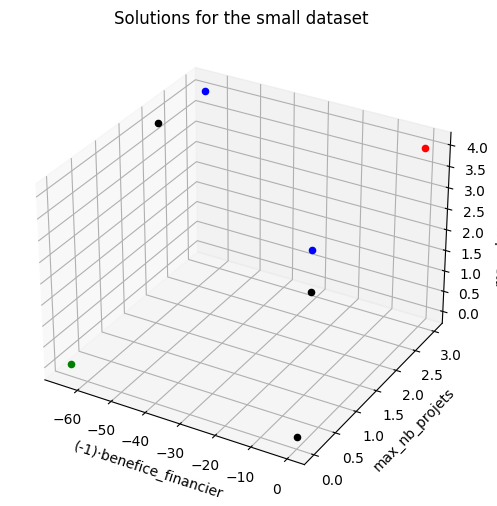

In [180]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define your 3D data
x = [small[i][0] for i in range(len(small))]
y = [small[i][1] for i in range(len(small))]
z = [small[i][2] for i in range(len(small))]
# Define the Nadir point and the ideal point
x_nadir, y_nadir, z_nadir = max(x), max(y), max(z)
x_id, y_id, z_id = min(x), min(y), min(z)
# Define a list of indices that you want to color differently
ND_indices = [ND_small[i][0] for i in range(len(ND_small))]
# Initialize a figure and 3D axis
fig = plt.figure()
fig.set_size_inches((6, 6))
ax = fig.add_subplot(111, projection='3d')
# Plot your data and color it accordingly
for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
    if i in ND_indices:
        color = 'black'
    else:
        color = 'b'
    ax.scatter(xi, yi, zi, c=color)
ax.scatter(x_nadir, y_nadir, z_nadir, c='red')
ax.scatter(x_id, y_id, z_id, c='green')
# Add labels to the axes
ax.set_xlabel("(-1)·benefice_financier")
ax.set_ylabel("max_nb_projets")
ax.set_zlabel("max_duree_projet")
# Show the plot
plt.title("Solutions for the small dataset")
plt.show()

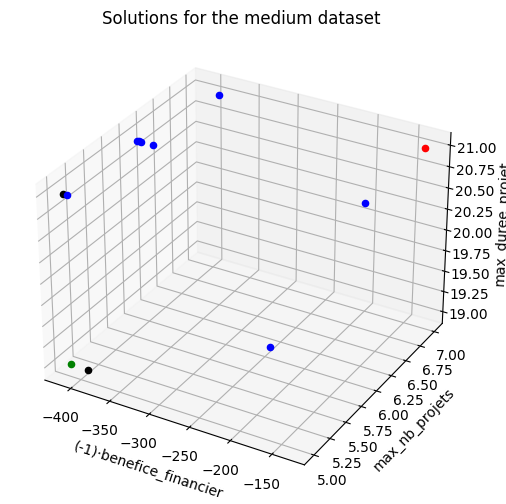

In [182]:
# Define your 3D data
x = [medium[i][0] for i in range(len(medium))]
y = [medium[i][1] for i in range(len(medium))]
z = [medium[i][2] for i in range(len(medium))]
# Define the Nadir point and the ideal point
x_nadir, y_nadir, z_nadir = max(x), max(y), max(z)
x_id, y_id, z_id = min(x), min(y), min(z)
# Define a list of indices that you want to color differently
ND_indices = [ND_medium[i][0] for i in range(len(ND_medium))]
# Initialize a figure and 3D axis
fig = plt.figure()
fig.set_size_inches((6, 6))
ax = fig.add_subplot(111, projection='3d')
# Plot your data and color it accordingly
for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
    if i in ND_indices:
        color = 'black'
    else:
        color = 'b'
    ax.scatter(xi, yi, zi, c=color)
ax.scatter(x_nadir, y_nadir, z_nadir, c='red')
ax.scatter(x_id, y_id, z_id, c='green')
# Add labels to the axes
ax.set_xlabel("(-1)·benefice_financier")
ax.set_ylabel("max_nb_projets")
ax.set_zlabel("max_duree_projet")
# Show the plot
plt.title("Solutions for the medium dataset")
plt.show()

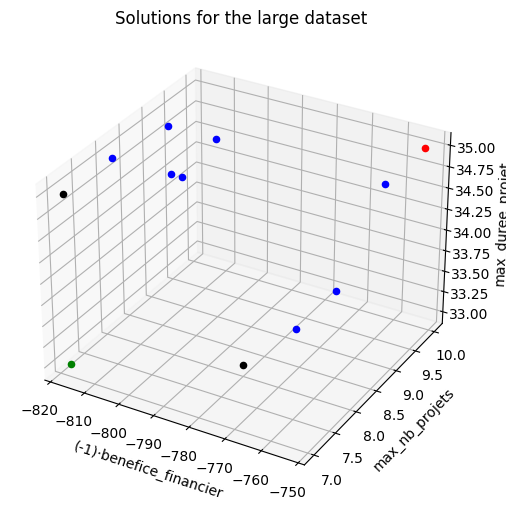

In [184]:
# Define your 3D data
x = [large[i][0] for i in range(len(large))]
y = [large[i][1] for i in range(len(large))]
z = [large[i][2] for i in range(len(large))]
# Define the Nadir point and the ideal point
x_nadir, y_nadir, z_nadir = max(x), max(y), max(z)
x_id, y_id, z_id = min(x), min(y), min(z)
# Define a list of indices that you want to color differently
ND_indices = [ND_large[i][0] for i in range(len(ND_large))]
# Initialize a figure and 3D axis
fig = plt.figure()
fig.set_size_inches((6, 6))
ax = fig.add_subplot(111, projection='3d')
# Plot your data and color it accordingly
for i, (xi, yi, zi) in enumerate(zip(x, y, z)):
    if i in ND_indices:
        color = 'black'
    else:
        color = 'b'
    ax.scatter(xi, yi, zi, c=color)
ax.scatter(x_nadir, y_nadir, z_nadir, c='red')
ax.scatter(x_id, y_id, z_id, c='green')
# Add labels to the axes
ax.set_xlabel("(-1)·benefice_financier")
ax.set_ylabel("max_nb_projets")
ax.set_zlabel("max_duree_projet")
# Show the plot
plt.title("Solutions for the large dataset")
plt.show()

# Visualisation des emplois du temps

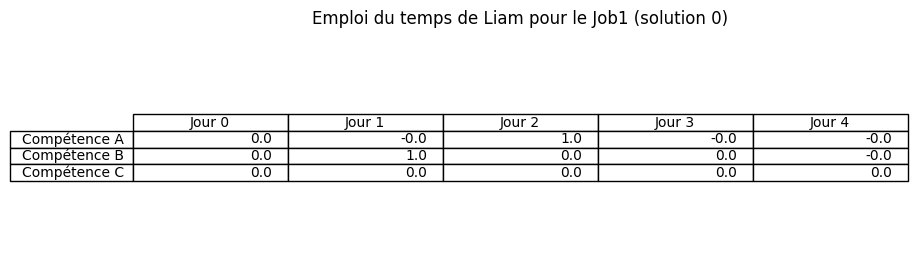

In [169]:
solutionid = 0 # ID de la solution à regarder
personid = 1 # ID de la personne à regarder
job_id = 0 # ID du jour à regarder

solution = solutions[solutionid]
matX = solution["X"]
person0 = matX[personid]

fig, ax = plt.subplots()
fig.set_size_inches((10, 3))

ax.axis('off')
ax.axis('tight')
ax.table(
    cellText=person0[job_id],
    colLabels=[f"Jour {k}" for k in range(H)],
    rowLabels=[f"Compétence {k}" for k in Q], loc='center'
)
plt.title(f"Emploi du temps de {S[personid]['name']} pour le {J[job_id]['name']} (solution {solutionid})")
plt.show()


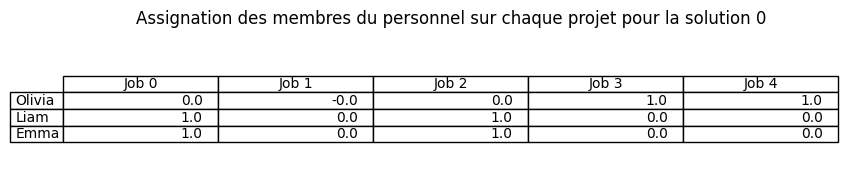

In [170]:
solution = solutions[solutionid]
mat_work_on = solution["works_on_job"]

fig, ax = plt.subplots()
fig.set_size_inches((10, 2))

ax.axis('off')
ax.axis('tight')
ax.table(
    cellText=mat_work_on,
    colLabels=[f"Job {k}" for k in range(len(J))],
    rowLabels=[f"{s['name']}" for s in S], loc='center'
)
plt.title(f"Assignation des membres du personnel sur chaque projet pour la solution {solutionid}")
plt.show()